In [ ]:
import tensorflow as tf
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
import numpy as np
from tensorflow.keras.utils import to_categorical  
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from scipy import interpolate

In [ ]:
batch_size = 64
img_width,img_height = 48,48

#ORIGINAL CLASSES 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
num_classes = 3 

CSV_FILE="../assets/fer2013.csv"

## Load Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CSV_FILE="/content/drive/My Drive/fer2013.csv" # please adjust the path
model_path = '/content/drive/My Drive/emotion_model_small.h5' # please adjust the path

## Prepare data 

In [ ]:
def _load_fer():
    # Load training and eval data
    df = pd.read_csv(CSV_FILE, sep=',')
    # 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral
    # 0=Neutral, 1=Happy, 2=Sad
    df = pd.read_csv(CSV_FILE, sep=',')
    print("Origin Size:", len(df))

    #drop all angry, disgust, fear, surprise
    df.drop(df.loc[df['emotion']==0].index, inplace=True)
    df.drop(df.loc[df['emotion']==1].index, inplace=True)
    df.drop(df.loc[df['emotion']==2].index, inplace=True)
    df.drop(df.loc[df['emotion']==5].index, inplace=True)

    #label emotions new
    df.loc[df['emotion'] == 3, 'emotion'] = 1
    df.loc[df['emotion'] == 4, 'emotion'] = 2
    df.loc[df['emotion'] == 6, 'emotion'] = 0
    print("End Size:", len(df))
    train_df = df[df['Usage'] == 'Training']
    eval_df = df[df['Usage'] == 'PublicTest']
    return train_df, eval_df

In [ ]:
def _preprocess_fer(df,
                    label_col='emotion',
                    feature_col='pixels'):
    labels, features = df.loc[:, label_col].values.astype(np.int32), [
        np.fromstring(image, np.float32, sep=' ')
        for image in df.loc[:, feature_col].values]
    
    labels = [to_categorical(l, num_classes=num_classes) for l in labels]

    features = np.stack((features,) * 3, axis=-1)
    features /= 255
    features = features.reshape(features.shape[0], img_width, img_height, 3)

    return features, labels

In [ ]:
# Load fer data
train_df, eval_df = _load_fer()

# preprocess fer data
x_train, y_train = _preprocess_fer(train_df)
x_valid, y_valid = _preprocess_fer(eval_df)

Origin Size: 35887
End Size: 21264


In [ ]:
print(x_train.shape[0], 'train samples')
print(x_valid.shape[0], 'valid samples')

17010 train samples
2155 valid samples


## Show train image

(48, 48, 3)


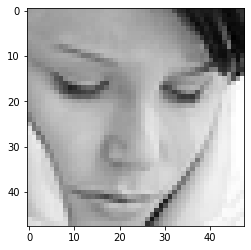

array([0., 0., 1.], dtype=float32)

In [ ]:
img = x_train[24]
print(img.shape)
plt.imshow(img)
plt.show()
y_train[24]

## Load images and labels in image generator

In [ ]:
gen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = gen.flow(x_train, y_train, batch_size=batch_size)
predict_size_train = int(np.math.ceil(len(x_train) / batch_size)) 

In [ ]:
gen = ImageDataGenerator()
valid_generator = gen.flow(x_valid, y_valid, batch_size=batch_size)
predict_size_valid = int(np.math.ceil(len(x_valid) / batch_size)) 

## Define Model with input, output and several layers

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(64,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/135
266/266 [==============================] - 49s 76ms/step - loss: 1.0876 - accuracy: 0.4220 - val_loss: 1.0776 - val_accuracy: 0.4204
Epoch 2/135
266/266 [==============================] - 20s 75ms/step - loss: 1.0741 - accuracy: 0.4312 - val_loss: 1.0745 - val_accuracy: 0.4162
Epoch 3/135
266/266 [==============================] - 20s 75ms/step - loss: 1.0721 - accuracy: 0.4338 - val_loss: 1.0665 - val_accuracy: 0.4334
Epoch 4/135
266/266 [==============================] - 20s 75ms/step - loss: 1.0700 - accuracy: 0.4340 - val_loss: 1.0641 - val_accuracy: 0.4334
Epoch 5/135
266/266 [==============================] - 20s 75ms/step - loss: 1.0678 - accuracy: 0.4399 - val_loss: 1.0553 - val_accuracy: 0.4441
Epoch 6/135
266/266 [==============================] - 20s 75ms/step - loss: 1.0655 - accuracy: 0.4313 - val_loss: 1.0589 - val_accuracy: 0.4343
Epoch 7/135
266/266 [==============================] - 20s 75ms/step - loss: 1.0658 - accuracy: 0.4365 - val_loss: 1.0550 - val_ac

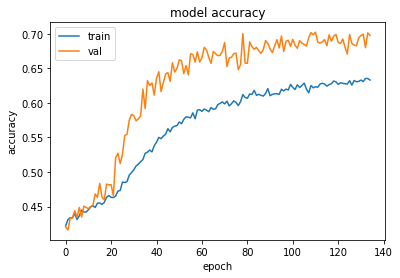

<Figure size 432x288 with 0 Axes>

In [ ]:
hist = model.fit(train_generator, 
                    steps_per_epoch=predict_size_train * 1, 
                    epochs=135,
                    validation_data=valid_generator,
                    validation_steps=predict_size_valid)
model.save('/content/drive/My Drive/models/emotionmodel_final_125_64')
import matplotlib.pyplot as plt
print(model)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('/content/drive/My Drive/plt_4.png')

# Create Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
x_valid, y_valid
y_pred = model.predict(x_valid)
predicted_category = tf.argmax(y_pred, axis=1)
true_category = tf.argmax(y_valid, axis=1)

confm = confusion_matrix(predicted_category, true_category)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm,
                      target_names,
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                      horizontalalignment="center",
                      color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
plot_confusion_matrix(cm = confm, 
                      normalize   = False,
                      target_names = ['neutral', 'happy', 'sad'],
                      title        = "Confusion Matrix")